# Weight and combine the chunk velocities

## Background

We have modelled all observations of our star and saved the results to file. To retrieve the RV timeseries of the star, we still need to combine the individual best-fit velocities of all 522 chunks for each observation. One might think of a simple mean or median over the chunk velocities within each observation to achieve this - but as we have seen [in the previous chapter](./observation.ipynb) we have quite a number of 'bad' chunks, with outlier velocities and huge errors. Also, some chunks contain more spectral information than others, deliver therefore more realistic results and should be weighted higher than poorly constraint outlier chunks.

In this script, we show how to run the combination routine. For a sound mathematical description, please check out our !!!paper!!!. But basically, weights are created for each chunk not only based on their 'velocity performance' within one observation, but also based on their performance throughout the whole timeseries. I.e. if the velocity timeseries of one chunk with index $i$ shows a highly significant scatter around the mean timeseries of all chunk velocities, that chunk receives lower weight *in all observations*!

## Run the code

First of, as before, we set up the path structure and import the velocity combination routine:

In [2]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.pyplot as plt
import numpy as np

# Put in the pyodine path on your machine here!
pyodine_path = '/home/holtz/git/pyodine/'

sys.path.append(pyodine_path)

import pyodine
import pyodine_combine_vels             # <- the velocity combination routine

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Again we load an object which contains all the important parameters for the velocity combination - this is the `Timeseries_Parameters` object:

In [3]:
import utilities_song as utilities

Pars = utilities.timeseries_parameters.Timeseries_Parameters()

Next, we need to specify the pathnames for the saved model results to use. We can also define pathnames for a directory where to save analysis plots, for a log-file with diagnosis information, and a text-file where to save the RV timeseries results in a human-readable format. Also, the combined model results (including best-fit results for all observations and chunks, and the RV timeseries along with additional information), represented as a `CombinedResults` object, can be saved to a HDF5-file whose pathname we also specify below.

In [4]:
# Individual result files to use
parent_dir = os.path.join(pyodine_path, 'tutorial_data/obs_results')
res_files = [os.path.join(parent_dir, f, f+'_res1.h5') for f in os.listdir(parent_dir)]
res_files.sort()

# The directory for analysis plots
plot_dir = os.path.join(pyodine_path, 'tutorial_data/vel_results')

# The output name of the CombinedResults object
comb_res_out = os.path.join(plot_dir, 'sigdra_tutorial_comb.h5')

# The output name of the velocity results text file
vels_out = os.path.join(plot_dir, 'sigdra_tutorial.vels')

# Log files
error_file = os.path.join(plot_dir, 'error.log')
info_file  = os.path.join(plot_dir, 'info.log')

Furthermore, to achieve highest precision in the barycentric correction (which is performed by the package [**barycorrpy**](https://github.com/shbhuk/barycorrpy)), we set up a dictionary with supplementary information which will overwrite the information extracted from the modelling results. **barycorrpy** comes with a built-in *Hipparcos*-atlas, which we can use to get reliable coordinates for the star (otherwise telescope coordinates from the original FITS-headers are used, which might be off sometimes). As the star's name in the modelling results (also extracted from the original FITS-headers) is 'HD185144', we will have to pass the corresponding HIP-identifier extra here (commented out you find other possible fields of the dictionary):

In [5]:
bary_dict = {
    'star_name': 'HIP96100',
    #'star_ra': 0.0,          # in deg
    #'star_dec': 0.0,
    #'star_pmra': 0.0,        # in mas/yr
    #'star_pmdec': 0.0,
    #'star_rv0': 0.0,         # in m/s
    #'instrument_lat': 0.0,   # in deg
    #'instrument_long': 0.0, 
    #'instrument_alt': 0.0    # in m
}

Finally, we run the velocity combination routine, which loads all the individual model results from file, computes the RV timeseries, performes the barycentric correction, and saves the `CombinedResults` object as well as some analysis plots and additional data as specified above. In the end the `CombinedResults` object is returned:

In [6]:
Results = pyodine_combine_vels.combine_velocity_results(
    Pars, res_files=res_files, plot_dir=plot_dir, comb_res_out=comb_res_out, 
    vels_out=vels_out, bary_dict=bary_dict, error_log=error_file, info_log=info_file)


Branch: master
Hash: bc51e2c
---------------------------
Weighting and combining velocities


100% (20 of 20) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00



Star: HD185144

Velocity weighting and combination...
---------------------------------------------------
- Pyodine chunk combination (based on iSONG code) -
---------------------------------------------------

Weighting parameters used:
	good_chunks	3	4	5	6	7	8	9	10	11	12	13	14	
	good_orders	6	7	8	9	10	11	12	13	
	sig_limit_low	4.0
	sig_limit_up	1000.0
	sig_correct	1000.0
	reweight_alpha	1.8
	reweight_beta	8.0
	reweight_sigma	2.0
	weight_correct	0.01

Nr. of obs, chunks per obs: 20, 528

Chunk-to-chunk offsets from observation mean:
Median: 6.63 +- 205.61

Chunk sigmas:
Median: 48.77 +- 35.98

RV quality factor 1 ( sqrt(1/sum(1/sig**2)) ): 1.76887 m/s
RV quality factor 2 ( sqrt(1/sum(med(wt1))) ): 1.76887 m/s

Doing the precise barycentric velocity correction...
Using BVC information from user-supplied dictionary...
BVC through HIP number: 96100

Writing results to txt file: /home/holtz/git/pyodine/tutorial_data/vel_results/sigdra_tutorial.vels

Saving combined results to /home/holtz/

Great, and again some print output to explain:

- First up, the weighting parameters used in the velocity combination (and supplied through the `Timeseries_Parameters` object) are printed. Also the code reports about the number of observations and chunks that it found in the results.

- Next, during the velocity combination algorithm, the (robust) mean and standard deviation (std) of the offsets of chunk timeseries from observation means are printed. Below, the mean and std of the velocity scatter within each chunk timeseries is reported ('Chunk sigmas'). The sigmas are used to weight the chunk velocities when computing the RV timeseries.

- Then, two 'quality factors' for the velocity weighting are reported. They should always be very similar, and as they basically represent an average RV precision achieved in this timeseries, you would want them to be as small as possible.

- Finally, the barycentric correction is performed for each observation with the Python package **barycorrpy**. Note that the output informs us about the *precise* correction being used - this corresponds to Equation 10 in [Wright and Eastman (2014)](https://arxiv.org/pdf/1409.4774.pdf), where the *absolute* Doppler shift as measured by the instrument is taken into account in a multiplicative way. As the authors explain, this can make a difference on the m/s-level as compared to a pure sum of *predicted* barycentric velocities with the measured radial velocities.

**Important:** As stated above, *absolute* measured RVs are needed for the precise barycentric correction, however in general the combined RVs in the I2 cell method are first only relative to the template observation, which has an RV offset with respect to laboratory wavelengths itself. Thankfully, in **pyodine**, during the template creation we have computed a template velocity offset with respect to the reference spectrum (which is at laboratory wavelengths), and that template velocity offset $RV_\mathrm{temp}$ is transported all the way through to the modelling results used in the velocity combination. So, we can use it to compute a good estimate of the *absolute* RVs:

$$
    RV_i^\mathrm{abs} = RV_i + RV_\mathrm{temp}
$$

In case you ever want to use a different template velocity offset (e.g. you have reason to believe that something went horribly wrong there), you can pass it into the velocity combination routine above as an additional argument `temp_vel=xxx.x` (in m/s). Similarly, if you've used a reference spectrum that is not at laboratory wavelengths, you can pass its velocity offset to the routine as `ref_vel=xxx.x`, and it will also be added to the individual RVs.

**Also Important:** One can also correct the observation times to the barycenter of the Solar System - in **barycorrpy** the corrected dates are called 'BJDTDB'. In **pyodine**, we refer to the original dates extracted from the observation FITS-headers as 'bary_date' (because this is the date when the barycentric correction should be performed), and we call the barycentric corrected dates 'bary_date_corr' (this refers to 'BJDTDB'). Make sure you use the correct one when using the combined velocities (we will use the corrected one below).

## Inspect the results

Now finally, after all this modelling, we can plot our RV timeseries. The barycentric dates, corrected RVs and uncertainties are available as attributes of the `CombinedResults` object called 'Results'.

Note: If you have passed a filepath to the argument `comb_res_out` in the velocity combination above (which we have done here), then this `CombinedResults` object is saved there as HDF5-file. Then, you can simply load it like this:

In [7]:
Results = pyodine.timeseries.base.CombinedResults(os.path.join(plot_dir, 'sigdra_tutorial_comb.h5'))

Loading combined results from /home/holtz/git/pyodine/tutorial_data/vel_results/sigdra_tutorial_comb.h5


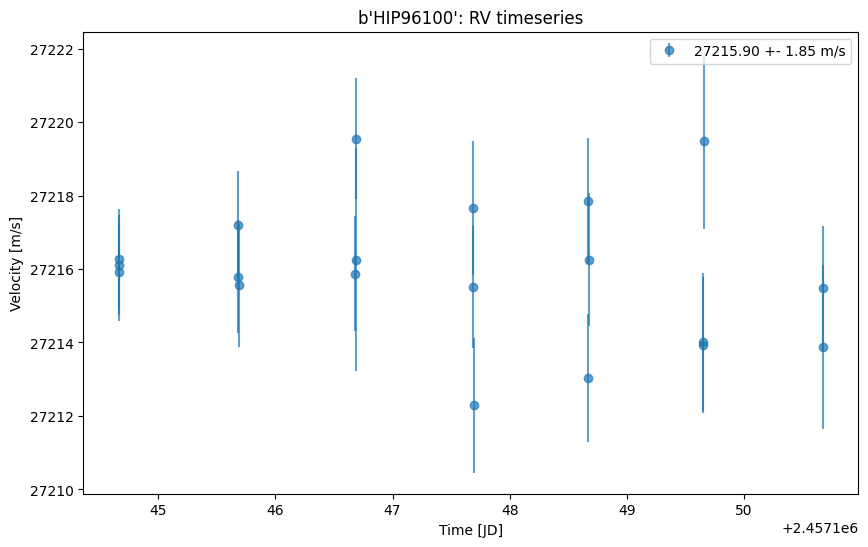

In [8]:
# The barycentric date, corrected bary date (shifted to solar system center),
# RV with barycentric correction, and RV uncertainty
bary_date      = Results.bary_date
bary_date_corr = Results.bary_date_corr
rv_bc          = Results.rv_bc
rv_err         = Results.rv_err

star_name = Results.info['star_name']     # the star name

# And plot
fig = plt.figure(figsize=(10,6))
plt.errorbar(bary_date_corr, rv_bc, yerr=rv_err, fmt='o', alpha=0.7,
            label='{:.2f} +- {:.2f} m/s'.format(np.mean(rv_bc), np.std(rv_bc)))
plt.legend()
plt.xlabel('Time [JD]')
plt.ylabel('Velocity [m/s]')
plt.title('{}: RV timeseries'.format(star_name))
plt.show()

In addition to the RV timeseries, the 'Results' object contains meta-information from the velocity weighting algorithm, that can help us to evaluate the trustworthyness of the results. For example, we can look at the scatter of individual chunk velocities (i.e. the robust standard deviation) for each observation:

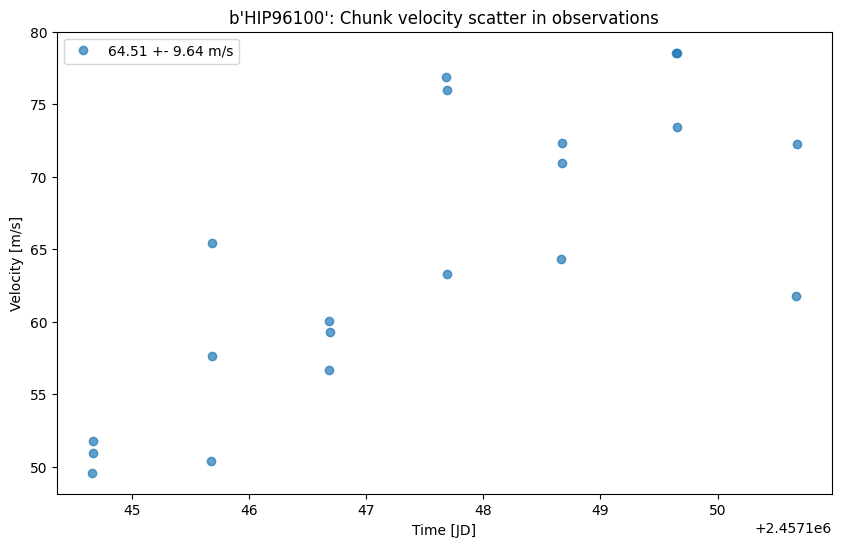

In [9]:
c2c_scatter = Results.c2c_scatter

fig = plt.figure(figsize=(10,6))
plt.plot(bary_date_corr, c2c_scatter, 'o', alpha=0.7,
        label='{:.2f} +- {:.2f} m/s'.format(np.mean(c2c_scatter), np.std(c2c_scatter)))
plt.legend()
plt.xlabel('Time [JD]')
plt.ylabel('Velocity [m/s]')
plt.title('{}: Chunk velocity scatter in observations'.format(star_name))
plt.show()

Even more: We can plot the chunk sigmas (velocity scatter within each chunk timeseries) over the mean counts of each chunk timeseries. We expect a downward correlation, where chunks with higher counts have smaller sigmas (as they should deliver a better estimate of the true RV in each observation):

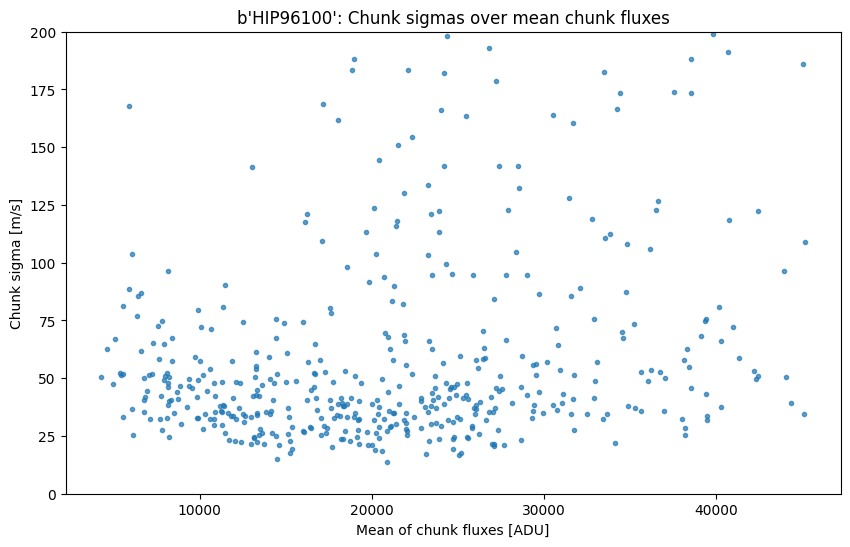

In [10]:
# Extract the median counts (medcnts) of each chunk in each observation, and average them over the observations
medcnts_mean = np.mean(Results.medcnts, axis=0)
# Extract the chunk sigmas
chunk_sigma  = Results.auxiliary['chunk_sigma']

fig = plt.figure(figsize=(10,6))
plt.plot(medcnts_mean, chunk_sigma, '.', alpha=0.7)
plt.xlabel('Mean of chunk fluxes [ADU]')
plt.ylabel('Chunk sigma [m/s]')
plt.ylim(0,200)
plt.title('{}: Chunk sigmas over mean chunk fluxes'.format(star_name))
plt.show()

The correlation is just there, but so are a lot of outliers - most of which are chunks at redder wavelengths, where tellurics and the fringing effect negatively impact the model.

In addition to the RV timeseries, the velocity weighting algorithm computes the so-called Chromatic Index for each observation - a measure of the slope of Doppler velocity over wavelength. It can be used as an activity indicator, as a varying Chromatic Index can be a sign of stellar spots leading to a RV variation (see e.g. [Reiners +2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...710..432R/abstract) for a physical description, and [Zechmeister +2017](https://ui.adsabs.harvard.edu/abs/2018A%26A...609A..12Z/abstract) for a code implementation and exemplary results).

**Note**: This is still very experimental - it is highly debatable how significant the Chromatic Index results from I2 cell codes are, or probably they only make sense for very high $S/N$-spectra, and we certainly need to test this more!

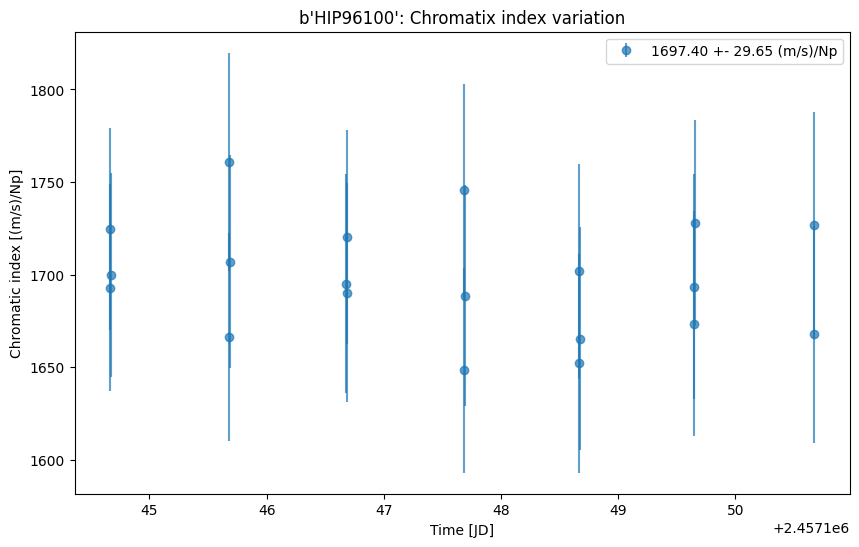

In [11]:
crx     = Results.crx
crx_err = Results.crx_err

fig = plt.figure(figsize=(10,6))
plt.errorbar(bary_date_corr, crx, yerr=crx_err, fmt='o', alpha=0.7,
            label='{:.2f} +- {:.2f} (m/s)/Np'.format(np.mean(crx), np.std(crx)))
plt.legend()
plt.xlabel('Time [JD]')
plt.ylabel('Chromatic index [(m/s)/Np]')
plt.title('{}: Chromatix index variation'.format(star_name))
plt.show()

Looks quite stable! And to give you an idea of what is measured by the Chromatic Index, let's plot the individual chunk velocities for one observation and overplot the fitted Chromatic Index model, which looks like:

$$
    v_\mathrm{fit} (\lambda) = RV + \beta \ln \frac{\lambda_\mathrm{RV}}{\lambda} \quad ,
$$

where $RV$ is the weighted RV of the observation, $\beta$ is the Chromatic Index, and $\lambda_\mathrm{RV}$ is the effective wavelength of the weighted RV.

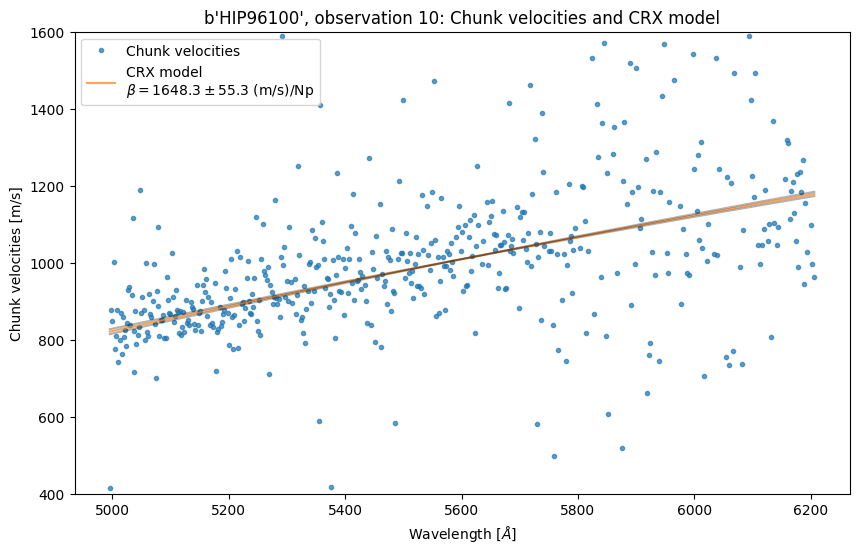

In [12]:
obs_ind = 10     # observation index

# The chunk wavelength intercepts of the observation
wave_int     = Results.params['wave_intercept'][obs_ind]
# The chunk velocities of the observation
velocity     = Results.params['velocity'][obs_ind]
# The weighted RV of the observation
rv_obs       = Results.rv[obs_ind]
# The CRX model effective wavelength of the RV (and error)
RV_wave      = Results.RV_wave[obs_ind]
RV_wave_err  = Results.RV_wave_err[obs_ind]
# The CRX model chromatic index (and error)
crx_obs      = Results.crx[obs_ind]
crx_obs_err  = Results.crx_err[obs_ind]

# Compute the velocities from the CRX model, along with upper and lower uncertainty
velocities_fit = pyodine.timeseries.combine_vels.velocity_from_chromatic_index(
    wave_int, rv_obs, RV_wave, crx_obs)
velocities_fit_lower = pyodine.timeseries.combine_vels.velocity_from_chromatic_index(
    wave_int, rv_obs-rv_err[obs_ind], RV_wave-RV_wave_err, crx_obs-crx_obs_err)
velocities_fit_upper = pyodine.timeseries.combine_vels.velocity_from_chromatic_index(
    wave_int, rv_obs+rv_err[obs_ind], RV_wave+RV_wave_err, crx_obs+crx_obs_err)

fig = plt.figure(figsize=(10,6))
plt.plot(wave_int, velocity, '.', alpha=0.7, label='Chunk velocities')
plt.plot(wave_int, velocities_fit, alpha=0.7, label='CRX model\n' + 
         r'$\beta={:.1f}\pm{:.1f}$ (m/s)/Np'.format(crx_obs, crx_obs_err))
plt.plot(wave_int, velocities_fit_lower, 'k', alpha=0.3)
plt.plot(wave_int, velocities_fit_upper, 'k', alpha=0.3)
plt.legend()
plt.xlabel(r'Wavelength [$\AA$]')
plt.ylabel('Chunk velocities [m/s]')
plt.ylim(400., 1600.)
plt.title('{}, observation {}: Chunk velocities and CRX model'.format(star_name, obs_ind))
plt.show()

Finally, here is an overview of the most important `CombinedResults` properties and variables:

| Parameter | Description |
| :- | :- |
| Results.params        | fit results of model parameters from all observations and chunks  |
| Results.errors        | fit errors of model parameters                                    |
| Results.orig_filename | list of observation filenames                                     |
| Results.res_filename  | list of model results filenames                                   |
| Results.chunks        | dictionary with information about chunks in all observations      |
| Results.redchi2       | red. $\chi^2$ of the fits in all observations/chunks              |
| Results.residuals     | relative residuals between model and observation in all observations/chunks |
| Results.medcnts       | median counts of all chunks in all observations                   |
| Results.info          | dictionary with general info (instrument, star, model used,...)   |
| Results.timeseries    | dictionary with timeseries parameters (these are directly accessible as properties) |
| Results.auxiliary     | dictionary with additional info from velocity combination (e.g. weights) |